Code for testing and the development of the simple bump modes scenario

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.latent_regression.scenarios import BumpInputWithRecursiveDynamicsScenario
from janelia_core.ml.latent_regression.scenarios import plot_2d_conditional_prior
from janelia_core.ml.latent_regression.scenarios import plot_2d_modes

from janelia_core.ml.latent_regression.vi import MultiSubjectVIFitter

### Parameters go here

In [3]:
n_subjects = 3
n_modes = 2
n_neuron_range = [1000, 1000]
n_dims = 2
n_smps_range = [1000, 1100]
prior_std = .001
noise_range = [.01, .02]
bump_std_range = [.1, .1]

### Generate priors and subject models

In [4]:
true_mdls = BumpInputWithRecursiveDynamicsScenario(n_subjects=n_subjects, 
                                                   n_modes=n_modes, 
                                                   n_neuron_range=n_neuron_range, 
                                                   n_dims=n_dims,
                                                   prior_std=prior_std, 
                                                   noise_range=noise_range, 
                                                   bump_std_range=bump_std_range)

### View prior modes

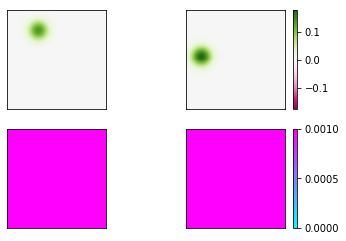

In [5]:
plot_2d_conditional_prior(true_mdls.input_u_prior)

### View modes for a given model

In [6]:
plot_s = 0

In [7]:
u = true_mdls.subject_mdls[plot_s].u[0].detach().numpy()
internal_p = true_mdls.subject_mdls[plot_s].p[1].detach().numpy()
neuron_p = true_mdls.subject_mdls[plot_s].neuron_pos.numpy()

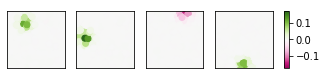

In [8]:
plot_2d_modes(modes=u, neuron_p=neuron_p)

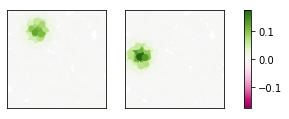

In [9]:
plot_2d_modes(modes=internal_p, neuron_p=neuron_p)

### Generate data from the models

In [10]:
n_smps = np.random.randint(n_smps_range[0], n_smps_range[1]+ 1, n_subjects)
subject_data = true_mdls.generate_random_input_data(n_smps, input_std=100)

### Fit one model use maximum likelihood

In [11]:
fit_s = 0

In [12]:
fit_data = subject_data[fit_s][0:-1]
fit_x = [t[fit_data.i_x,:] for t in fit_data.data]
fit_y = [fit_data.data[1][fit_data.i_y,:]]

In [13]:
fit_mdl = true_mdls.generate_training_subject_mdl(fit_s)

In [14]:
log = fit_mdl.fit(x=fit_x, y=fit_y, update_int=1000, max_its=3000, 
                          learning_rates=.001, batch_size=100, send_size=100)

0: Elapsed fitting time 0.00013208389282226562, vl: 166037.03, lr: 0.001
1000: Elapsed fitting time 1.6630711555480957, vl: -125.87038, lr: 0.001
2000: Elapsed fitting time 3.201244354248047, vl: -345.1264, lr: 0.001
2999: Elapsed fitting time 4.703498125076294, vl: -481.918


#### Look at fit u modes

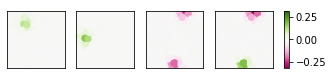

In [15]:
u_fit = fit_mdl.u[0].detach().numpy()
internal_p_fit = fit_mdl.p[1].detach().numpy()
neuron_p_fit = true_mdls.subject_mdls[fit_s].neuron_pos.detach()

plot_2d_modes(modes=u_fit, neuron_p=neuron_p_fit)

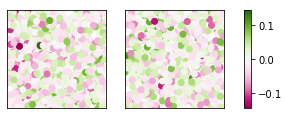

In [16]:
plot_2d_modes(modes=internal_p_fit, neuron_p=neuron_p_fit)

### Fit everything with variational inference

In [17]:
prior_dists = true_mdls.generate_fitting_priors()

In [18]:
subject_collections = [true_mdls.generate_training_collection(s_i=s_i, data=data)
                      for s_i, data in enumerate(subject_data)]

In [19]:
vi_fitter = MultiSubjectVIFitter(p_priors=prior_dists[0], u_priors=prior_dists[1], 
                                 s_collections=subject_collections)

In [30]:
logs=vi_fitter.fit(n_epochs=100, n_batches=10, update_int=10, 
                   learning_rates=.001)

*****************************************************
Epoch 0 complete.  Obj: 1621085.2, LR: 0.001
Model NLLs:  s_0: 575704.625, s_1: 520722.4375, s_2: 516693.78125
Subj P KLs:  s_0: 276.7784729003906, s_1: 239.1550750732422, s_2: 287.3834228515625
Subj U KLs:  s_0: 2456.91748046875, s_1: 2285.3720703125, s_2: 2418.83447265625
*****************************************************
Epoch 10 complete.  Obj: 1270558.4, LR: 0.001
Model NLLs:  s_0: 412063.96875, s_1: 370512.875, s_2: 481764.65625
Subj P KLs:  s_0: 163.19789123535156, s_1: 199.78652954101562, s_2: 246.50833129882812
Subj U KLs:  s_0: 1934.7509765625, s_1: 1755.59033203125, s_2: 1917.1827392578125
*****************************************************
Epoch 20 complete.  Obj: 1022292.6, LR: 0.001
Model NLLs:  s_0: 320115.84375, s_1: 356997.5, s_2: 338389.5
Subj P KLs:  s_0: 178.01959228515625, s_1: 209.3731689453125, s_2: 237.81671142578125
Subj U KLs:  s_0: 2116.716796875, s_1: 1942.9815673828125, s_2: 2104.817138671875
******

#### Look at log values

Text(0.5, 0, 'Elapsed Time')

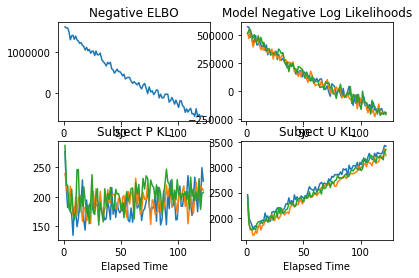

In [31]:
plt.subplot(2,2,1)
plt.plot(logs['elapsed_time'], logs['nelbo'])
plt.title('Negative ELBO')
plt.xlabel('Elapsed Time')

plt.subplot(2,2,2)
plt.plot(logs['elapsed_time'], logs['mdl_nll'])
plt.title('Model Negative Log Likelihoods')
plt.xlabel('Elapsed Time')

plt.subplot(2,2,3)
plt.plot(logs['elapsed_time'], logs['sub_p_kl'])
plt.title('Subject P KL')
plt.xlabel('Elapsed Time')

plt.subplot(2,2,4)
plt.plot(logs['elapsed_time'], logs['sub_u_kl'])
plt.title('Subject U KL')
plt.xlabel('Elapsed Time')

#### Look at fit modes for one subject

In [32]:
fit_s = 0
neuron_u_pos = true_mdls.subject_mdls[fit_s].neuron_pos

u_mn = subject_collections[fit_s].u_dists[0].form_standard_sample(
    subject_collections[fit_s].u_dists[0].sample(neuron_u_pos)).cpu().detach().numpy()

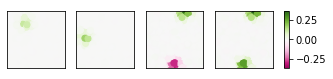

In [33]:
plot_2d_modes(modes=u_mn, neuron_p=neuron_u_pos)

#### Look at prior modes

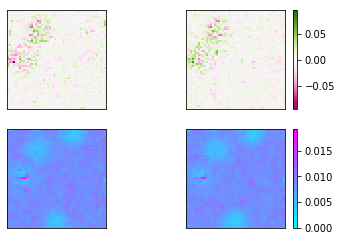

In [36]:
plot_2d_conditional_prior(prior_dists[0][1])

In [ ]:
,m